In [1]:
from pathlib import Path

while Path.cwd().name != 'retrieval-model-safety':
    %cd ..

%matplotlib inline

/home/luiza_cohere_com/retrieval-model-safety


In [2]:
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

sns.set(context="paper", style="white", font_scale=1.5, palette="RdBu")

In [3]:
model = "gpt2_toxigen"
varied_var = "alpha"
folder = "small_prompted_exp_patch_min"

base_folder = Path(f"outputs/{model}/ensemble/{folder}")

experiment_folder = base_folder
assert experiment_folder.exists()

metrics = ["perplexity", "toxicity", "diversity"]

In [4]:
metrics_dfs = {}
for metric in metrics:
    files = list(experiment_folder.rglob(f"*{metric}.csv"))
    metric_df = pd.DataFrame()
    for file in files:
        df = pd.read_csv(file, index_col=0)
        
        if metric == "toxicity":
            df = df.T.reset_index().melt(id_vars="index", value_name="value", var_name="metric").rename(columns={"index": "mode"})

        df[varied_var] = float(file.parent.name.split("_")[-1])
        df["temperature"] = float(file.parents[3].name.split("_")[-1])
        df["dstore"] = file.parents[1].name
        
        metric_df = pd.concat([metric_df, df])
    if metric in ["perplexity", "diversity", "perplexity_ours"]:
        metric_df = metric_df.melt(var_name="mode", value_name="value", id_vars=[varied_var, "temperature", "dstore"])
    metrics_dfs[metric] = metric_df.reset_index(drop=True)

In [5]:
big_alphas = False
alpha_comp = ">=" if big_alphas else "<="

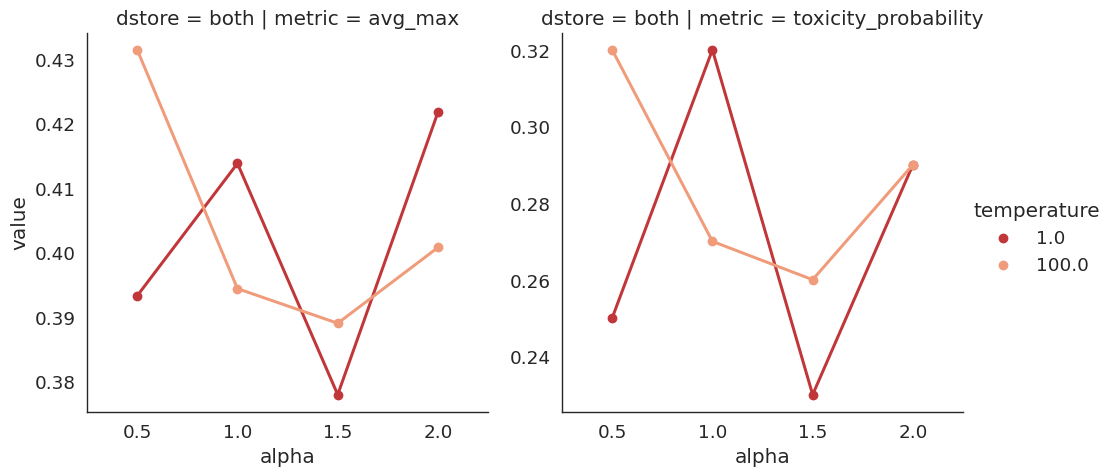

In [6]:
sns.catplot(
    data=metrics_dfs["toxicity"].query(f"mode == 'nontoxic' and metric != 'std_max' and alpha {alpha_comp} 2.0 and alpha < 20"), 
    x="alpha", 
    y="value", 
    hue="temperature",
    col="metric",
    row="dstore", 
    kind="point",
    sharey=False,
)
# plt.suptitle("Toxicity metrics. Lower is better.")
# plt.tight_layout()
plt.show()

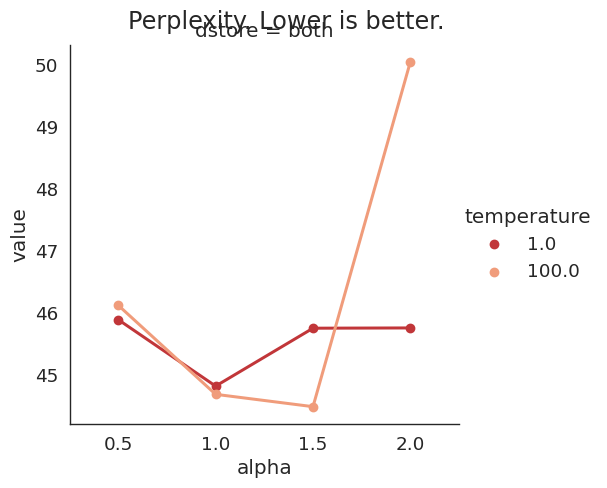

In [7]:
sns.catplot(
    data=metrics_dfs["perplexity"].query(f"mode == 'nontoxic' and alpha {alpha_comp} 2.0 and alpha < 20"), 
    x="alpha", 
    y="value", 
    hue="temperature",
    col="dstore", 
    kind="point",
    sharey=True,
)
plt.suptitle("Perplexity. Lower is better.")
plt.show()

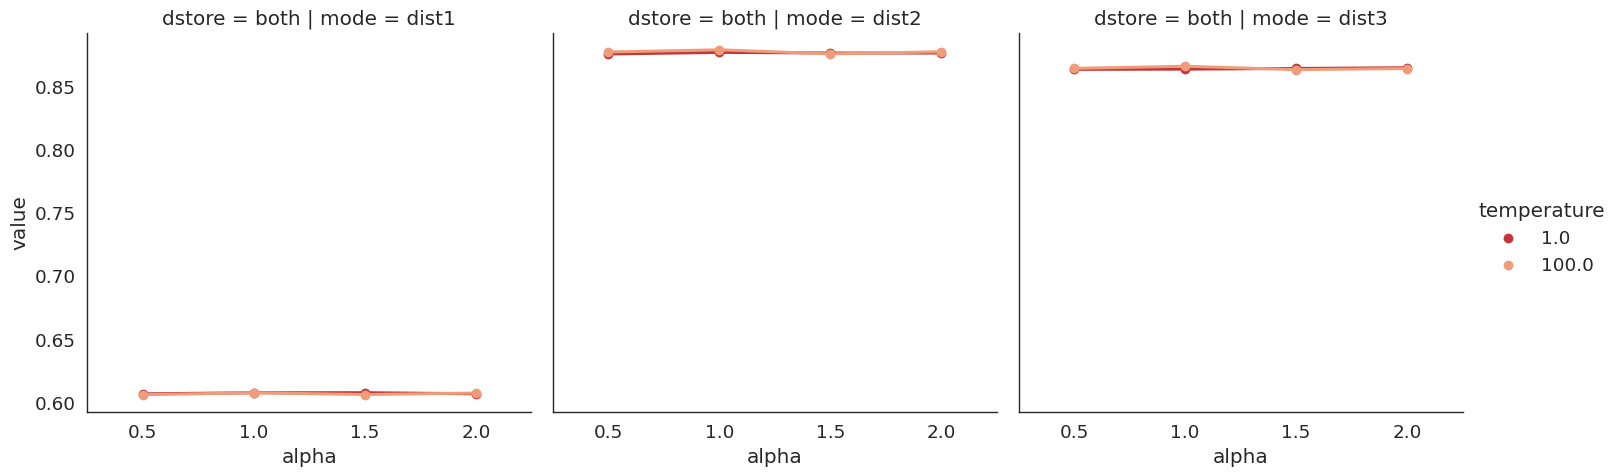

In [8]:
sns.catplot(
    data=metrics_dfs["diversity"].query(f"alpha {alpha_comp} 2 and alpha < 20"), 
    x="alpha", 
    y="value", 
    hue="temperature",
    row="dstore", 
    col="mode", 
    kind="point"
)
# plt.title("Diversity metrics. Higher is better.")
plt.show()